In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import random
random.seed(1100038344)
import survivalstan
import numpy as np
import pandas as pd
from stancache import stancache
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
print(survivalstan.models.pem_survival_model_gamma)

/*  Variable naming:
 // dimensions
 N          = total number of observations (length of data)
 S          = number of sample ids
 T          = max timepoint (number of timepoint ids)
 M          = number of covariates
 
 // data
 s          = sample id for each obs
 t          = timepoint id for each obs
 event      = integer indicating if there was an event at time t for sample s
 x          = matrix of real-valued covariates at time t for sample n [N, X]
 obs_t      = observed end time for interval for timepoint for that obs
 
*/
// Jacqueline Buros Novik <jackinovik@gmail.com>


data {
  int<lower=1> N;
  int<lower=1> S;
  int<lower=1> T;
  int<lower=0> M;
  int<lower=1, upper=N> s[N];     // sample id
  int<lower=1, upper=T> t[N];     // timepoint id
  int<lower=0, upper=1> event[N]; // 1: event, 0:censor
  matrix[N, M] x;                 // explanatory vars
  real<lower=0> obs_t[N];         // observed end time for each obs
  real<lower=0> t_dur[T];
  real<lower=0> t_obs[T];
}
t

In [11]:
d = stancache.cached(
    survivalstan.sim.sim_data_exp_correlated,
    N=100,
    censor_time=20,
    rate_form='1 + sex',
    rate_coefs=[-3, 0.5],
)
d['age_centered'] = d['age'] - d['age'].mean()
d.head()

INFO:stancache.stancache:sim_data_exp_correlated: cache_filename set to sim_data_exp_correlated.cached.N_100.censor_time_20.rate_coefs_54462717316.rate_form_1 + sex.pkl
INFO:stancache.stancache:sim_data_exp_correlated: Starting execution
INFO:stancache.stancache:sim_data_exp_correlated: Execution completed (0:00:00.008278 elapsed)
INFO:stancache.stancache:sim_data_exp_correlated: Saving results to cache


,age,sex,rate,true_t,t,event,index,age_centered
0,66,male,0.082085,10.147691,10.147691,True,0,10.68
1,56,female,0.049787,0.367137,0.367137,True,1,0.68
2,64,male,0.082085,9.405635,9.405635,True,2,8.68
3,50,female,0.049787,37.622991,20.000000,False,3,-5.32
4,51,female,0.049787,18.443852,18.443852,True,4,-4.32


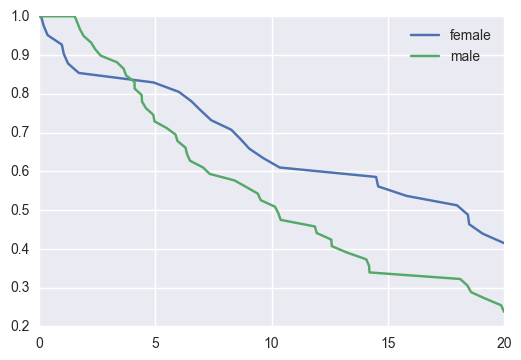

In [12]:
survivalstan.utils.plot_observed_survival(df=d[d['sex']=='female'], event_col='event', time_col='t', label='female')
survivalstan.utils.plot_observed_survival(df=d[d['sex']=='male'], event_col='event', time_col='t', label='male')
plt.legend()

In [13]:
dlong = survivalstan.prep_data_long_surv(df=d, event_col='event', time_col='t')
dlong.sort_values(['index','end_time'], inplace=True)

In [14]:
dlong.head()

,age,sex,rate,true_t,t,event,index,age_centered,key,end_time,end_failure
17,66,male,0.082085,10.147691,10.147691,True,0,10.68,1,0.085974,False
59,66,male,0.082085,10.147691,10.147691,True,0,10.68,1,0.195506,False
1,66,male,0.082085,10.147691,10.147691,True,0,10.68,1,0.367137,False
68,66,male,0.082085,10.147691,10.147691,True,0,10.68,1,0.978347,False
58,66,male,0.082085,10.147691,10.147691,True,0,10.68,1,1.064155,False


In [15]:
testfit = survivalstan.fit_stan_survival_model(
    model_cohort = 'test model',
    model_code = survivalstan.models.pem_survival_model_gamma,
    df = dlong,
    sample_col = 'index',
    timepoint_end_col = 'end_time',
    event_col = 'end_failure',
    formula = '~ age_centered + sex',
    iter = 5000,
    chains = 4,
    seed = 9001,
    FIT_FUN = stancache.cached_stan_fit,
    )


INFO:stancache.stancache:Step 1: Get compiled model code, possibly from cache
INFO:stancache.stancache:StanModel: cache_filename set to anon_model.cython_0_25_1.model_code_72990130769.pystan_2_12_0_0.stanmodel.pkl
INFO:stancache.stancache:StanModel: Starting execution
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4e9967af60f8a4c8a22e064ae4316828 NOW.
INFO:stancache.stancache:StanModel: Execution completed (0:00:41.611150 elapsed)
INFO:stancache.stancache:StanModel: Saving results to cache
INFO:stancache.stancache:Step 2: Get posterior draws from model, possibly from cache
INFO:stancache.stancache:sampling: cache_filename set to anon_model.cython_0_25_1.model_code_72990130769.pystan_2_12_0_0.stanfit.chains_4.data_86944583742.iter_5000.seed_9001.pkl
INFO:stancache.stancache:sampling: Starting execution
INFO:stancache.stancache:sampling: Execution completed (0:05:39.032850 elapsed)
INFO:stancache.stancache:sampling: Saving results to cache
/Users/jacquelineburos/anaconda3/envs/p

In [16]:
survivalstan.utils.print_stan_summary([testfit], pars='lp__')

            mean   se_mean        sd        2.5%        50%       97.5%      Rhat
lp__ -940.118774  0.183353  6.867781 -954.551859 -939.65504 -927.878234  1.002961


In [17]:
survivalstan.utils.print_stan_summary([testfit], pars='log_baseline')

                        mean   se_mean          sd        2.5%         50%      97.5%      Rhat
log_baseline[0]    -5.458445  0.023944    1.277371   -8.551072   -5.255073  -3.554801  1.001118
log_baseline[1]    -5.503284  0.031544    1.367357   -8.922270   -5.271585  -3.526857  1.004228
log_baseline[2]    -5.488196  0.030110    1.356308   -8.814297   -5.270812  -3.558143  1.002805
log_baseline[3]    -5.391718  0.023086    1.235493   -8.324726   -5.209947  -3.491102  1.000807
log_baseline[4]    -5.465735  0.030928    1.318725   -8.665506   -5.226711  -3.575818  1.002776
log_baseline[5]    -5.418533  0.025469    1.267851   -8.477245   -5.224016  -3.502142  1.001764
log_baseline[6]    -5.442556  0.025202    1.300066   -8.616056   -5.233685  -3.522778  1.000943
log_baseline[7]    -5.442247  0.026916    1.294190   -8.419455   -5.247620  -3.511516  1.001089
log_baseline[8]    -5.395676  0.027285    1.270731   -8.570940   -5.190516  -3.521473  1.001084
log_baseline[9]    -5.402306  0.027479  

INFO:survivalstan.utils:Warning - 1 rows removed due to NaN values for Rhat. This may indicate a problem in your model estimation.


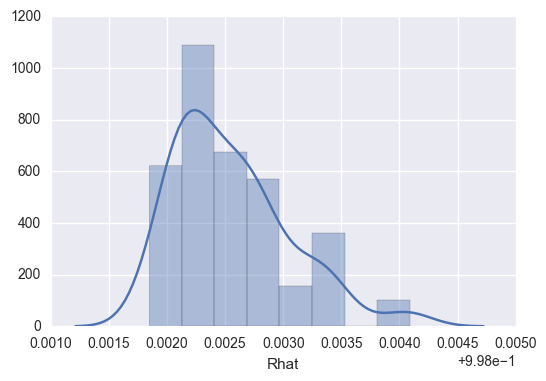

In [18]:
survivalstan.utils.plot_stan_summary([testfit], pars='baseline')

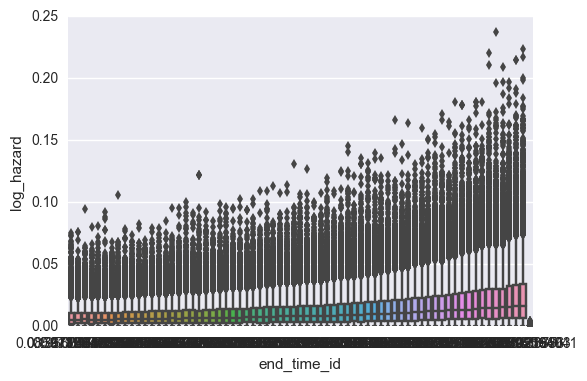

In [19]:
survivalstan.utils.plot_coefs([testfit], element='baseline')

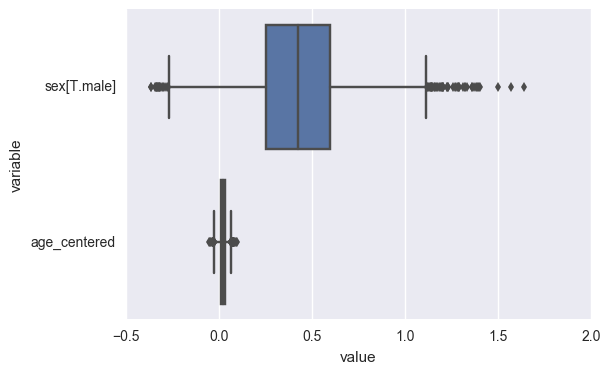

In [20]:
survivalstan.utils.plot_coefs([testfit])

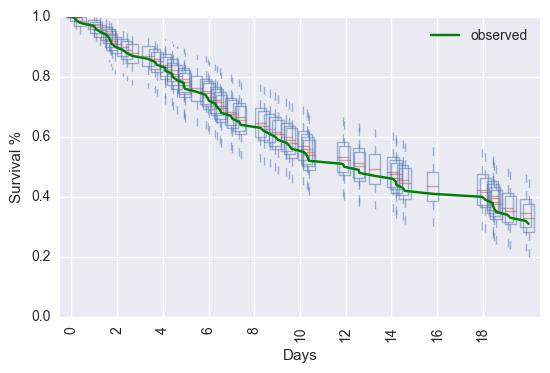

In [21]:
survivalstan.utils.plot_pp_survival([testfit], fill=False)
survivalstan.utils.plot_observed_survival(df=d, event_col='event', time_col='t', color='green', label='observed')
plt.legend()

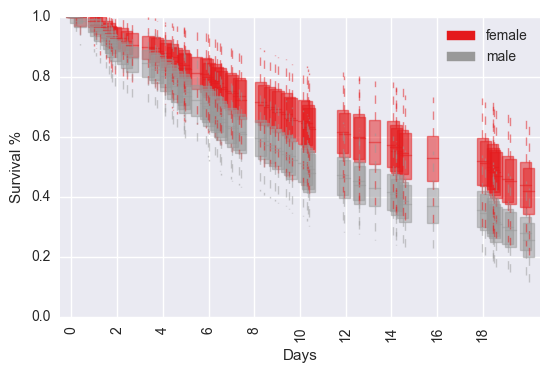

In [22]:
survivalstan.utils.plot_pp_survival([testfit], by='sex')